This notebook demonstrates a PDOT simulation with a moving barrier. The resulting density snapshots are saved in `examples/figures/moving_barrier_density_with_maze_snapshots.png`.

/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


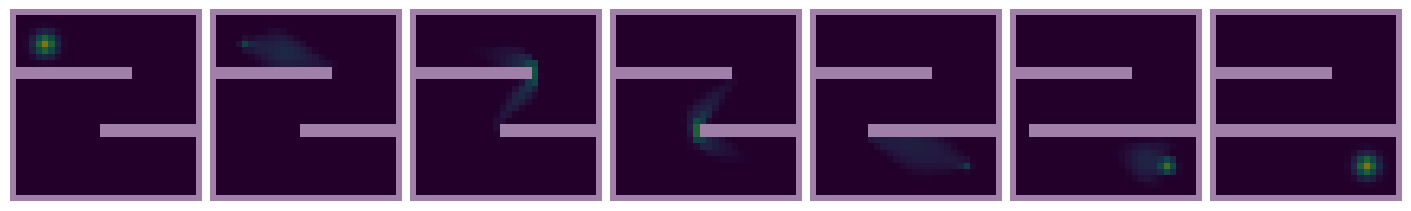

In [1]:

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.dynamicUOT import computeGeodesic
from PIL import Image

# Load maze and define moving barrier
maze = (1 - np.array(Image.open('input/maze.png').convert('L')) / 255)
T = 30
F = np.zeros((T,))

end_col = 30
step_size = end_col / T
frames = [maze.copy()]
for i in range(1, T):
    frame = frames[-1].copy()
    end_fill = max(1, int(end_col - i * step_size))
    frame[18:20, end_fill:14] = 1.0
    frames.append(frame)
H = np.stack(frames, axis=0)

# Source and target densities
indices = np.arange(0,30)/30
xx,yy = np.meshgrid(indices,indices)
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx,yy],axis=-1), mean=[5./30.,5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx,yy],axis=-1), mean=[24./30.,24./30.], cov=2./36**2)

ll=(1.0,1.0,1.0)
x,_ = computeGeodesic(rho_0, rho_1, T, ll, H, F, p=2.0, q=2.0, delta=10.0, niter=1000, big_matrix=True)

# Snapshot plot
snap_fracs=[0.0,0.1,0.3,0.5,0.7,0.9,1.0]
idx=[int(round(f*T)) for f in snap_fracs]
H_add=np.concatenate([H,H[-1].reshape(1,*H.shape[1:])],0)
densities=[rho_0]+[x.V.D[0][k] for k in idx[1:-1]]+[rho_1]
obstacles=[H_add[k]>0 for k in idx]
vmin=min(d.min() for d in densities)
vmax=max(d.max() for d in densities)
fig,axes=plt.subplots(1,len(snap_fracs),figsize=(14,3),constrained_layout=True)
for ax,d,o in zip(axes,densities,obstacles):
    ax.imshow(d, cmap='viridis', vmin=vmin, vmax=vmax, origin='upper')
    ax.imshow(o, cmap='Greys_r', alpha=0.5, origin='upper')
    ax.axis('off')
fig.savefig('figures/moving_barrier_density_with_maze_snapshots.png', dpi=300, bbox_inches='tight')
plt.show()
